<h2>Initialize all imports</h2>

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import copy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import importlib
import keras.backend as K
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers, constraints, callbacks

import sys
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

import time

2025-08-11 15:46:43.988295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-11 15:46:44.074382: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

## Read Input data & Change directory

In [2]:
# Depickle the PDB(Protein Data Bank) and read csv with data
PDBs = pickle.load(open('Datasets/PDBs_RDKit_BFE.pkl', 'rb'))
df = pd.read_csv('Datasets/Final_data_DDG.csv')


In [3]:
import models.layers_update_mobley as layers
from models.dcFeaturizer import atom_features as get_atom_features
importlib.reload(layers)
from models.PGCN_model_multiloss import get_trained_model, test_model

## Data pre-processing

In [4]:
# Iterate through each pdb. Look at current pdb position (row) and extract the information and store as a numpy array
# Note: Host is the receptor component which provides the binding site
# - Guest is the molecule that binds to the host
# - Complex is the bound state between guest and host and typically binding energy
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])

In [5]:
# Function takes in a molecule and information

def featurize(molecule, info):
    atom_features = []
    # Iterate through each atom
    for atom in molecule.GetAtoms():
        # List of features for the atom
        new_feature = get_atom_features(atom).tolist() 
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        # Store mass, atomic number, formal charge
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        # Store 3D position
        new_feature += [position.x, position.y, position.z]
        # Track neighboring atoms
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

In [6]:
# X is the featurized molecule and y is the experimental binding free energy
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])


[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValen

[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[15:46:59] DEPRECATION WARNING: please use GetValen

In [7]:
# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)


(57, 15, 57, 15)

## Helper Functions

<h3 style="color:red;">PCGrad Class</h3>

In [9]:
print(tf.__version__)

2.11.1


In [10]:
import tensorflow as tf
import numpy as np

class PCGrad(tf.keras.optimizers.Optimizer):
    def __init__(self, optimizer, name="PCGrad", **kwargs):
        # MUST be called first!
        super().__init__(name=name, **kwargs)
        self._optimizer = optimizer
    @property
    def learning_rate(self):
        return self._optimizer.learning_rate

    def apply_gradients(self, grads_and_vars, name=None, **kwargs):
        return self._optimizer.apply_gradients(grads_and_vars, name, **kwargs)

    def _create_slots(self, var_list):
        self._optimizer._create_slots(var_list)

    def _prepare(self, var_list):
        self._optimizer._prepare(var_list)

    def get_config(self):
        config = super().get_config()
        config.update({"optimizer": tf.keras.optimizers.serialize(self._optimizer)})
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        optimizer_config = config.pop("optimizer")
        optimizer = tf.keras.optimizers.deserialize(optimizer_config, custom_objects=custom_objects)
        return cls(optimizer, **config)

    def compute_gradients(self, losses, tape, var_list):
        """Compute PCGrad projected gradients from a list of task losses."""
        assert isinstance(losses, list), "loss must be a list of task losses"
        grads_task = losses

        for loss in losses:
            grads = tape.gradient(loss, var_list)
            grads = [tf.zeros_like(v) if g is None else g for g, v in zip(grads, var_list)]
            grads_task.append(grads)

        # Flatten and apply projection
        def flatten(grads):
            return tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)

        flat_grads_task = [flatten(g) for g in grads_task]
        flat_grads_task = tf.stack(flat_grads_task)
        flat_grads_task = tf.random.shuffle(flat_grads_task)

        def project(g, others):
            for o in others:
                dot = tf.reduce_sum(g * o)
                if dot < 0:
                    g -= dot / (tf.reduce_sum(o * o) + 1e-12) * o
            return g

        projected = []
        for i in range(len(flat_grads_task)):
            others = tf.concat([flat_grads_task[:i], flat_grads_task[i+1:]], axis=0)
            projected.append(project(flat_grads_task[i], others))
        projected = tf.stack(projected)

        # Average the projected gradients and reshape
        mean_grad = tf.reduce_mean(projected, axis=0)

        reshaped_grads = []
        idx = 0
        for v in var_list:
            shape = tf.shape(v)
            size = tf.reduce_prod(shape)
            reshaped_grads.append(tf.reshape(mean_grad[idx:idx + size], shape))
            idx += size

        return list(zip(reshaped_grads, var_list))

In [11]:
opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=1e-3))

2025-08-11 15:47:03.786715: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-11 15:47:03.786779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-08-11 15:47:03.790382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
class PGGCN_Hybrid(tf.keras.Model):
    # num_atom_features - number of features per atom
    # r_out_channel - number of output channels for graph convolutional layer (size of each output sample)
    # c_out_channel - number of output channels convolutional layer (size of each output sample)
    # l2 - regularization coefficient
    # drouput_rate - dropout rate for regularization (helps reduce overfitting)
    # maxnorm - norm constraint for the weight vectors
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        # Initialize RuleGraphConvLayer and set the out_channel to be 20 and number of features to be 36
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        # Initialize empty list of combination rules
        self.ruleGraphConvLayer.combination_rules = []
        # Initialize the Convolutional layer. Set the out_channel to be 128 and number of features as the other out_channel (20)
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        # Set the dense layer to 32 units, relu activation, use kernel regularizer l2 and use it as a bias regularizer, and add maxnorm constraint
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        # Set the dropout rate
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        # Set dense layer to 16 units and same activation, regularizer, and maxnorm constraint
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        # The weights have been manually set to a specific pattern based on the physics coefficients
        # Bias innitializers are set to 0 so there is no offset (rely on weights and features)
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))

    # adds rule to RuleGraphConvLayer (see layers_update_mobley.py)
    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    # It's internal and it's called everytime you call the class and sets the physics info and it's run through the labels 
    def call(self, inputs, training=True):
        print("Inside call")
        physics_info = inputs[:, 0, 38:]
        #x_a = [inputs[i, :, :38] for i in range(tf.shape(inputs)[0])]

        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return tf.concat([out, physics_info], axis=1)
    
empirical_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)
physics_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)

# Callback function which displays empirical loss, physical loss, totall loss and learning rates for each epoch
class LossComponentsCallback_Hybrid(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.empirical_losses = []
        self.physical_losses = []
        self.total_losses = []
        self.learning_rates = []
        self.model_instance = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model_instance.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))
        self.empirical_losses.append(float(empirical_loss_value.numpy()))
        self.physical_losses.append(float(physics_loss_value.numpy()))
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model_instance.optimizer.iterations)  # Call the schedule
        else:
            lr = lr  

        self.learning_rates.append(float(tf.keras.backend.get_value(lr)))


def pure_rmse_hybrid(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    return K.sqrt(K.mean(K.square(y_pred - y_true_flat)))

def physical_consistency_loss(y_true,y_pred,physics_info):
    dG_pred = y_pred
    y_true = tf.reshape(y_true, (-1, 1))

    # Physical Inconsistency loss
    # Extract the components from physics_info
    host = tf.gather(physics_info, [0, 3, 6, 9, 12], axis=1)  # Host energy terms
    guest = tf.gather(physics_info, [1, 4, 7, 10, 13], axis=1)  # Guest energy terms
    complex_ = tf.gather(physics_info, [2, 5, 8, 11, 14], axis=1)  # Complex energy terms

    # Calculate ΔG based on physics: ΔG = ΔGcomplex - (ΔGhost + ΔGguest)
    dG_physics = tf.reduce_sum(complex_, axis=1, keepdims=True) - (tf.reduce_sum(host, axis=1, keepdims=True) + tf.reduce_sum(guest, axis=1, keepdims=True))
    phy_loss = K.sqrt(K.mean(K.square(dG_pred - dG_physics)))
    

    return phy_loss


# Output of the empirical loss is going to be a tensor and we have to convert it into a number value
def combined_loss(physics_hyperparam=0.0003):
    
    def loss_function(y_true, y_pred):
        # Extract prediction and physics info
        prediction = y_pred[:, 0]
        physics_info = y_pred[:, 1:16]  # Assuming 15 physical features
        
        # Calculate individual loss components
        empirical_loss = pure_rmse_hybrid(y_true, prediction)
        physics_loss = physical_consistency_loss(y_true, prediction, physics_info)
        
        # Append losses to a list and return
        losses = []
        losses.append(empirical_loss)
        losses.append(physics_loss)
        
        # Keep track each of the loss values. Total loss is returned
        # The value ones are logs for the history
        total_loss = empirical_loss + (physics_hyperparam * physics_loss)
        empirical_loss_value.assign(empirical_loss)
        physics_loss_value.assign(physics_loss) 

        return total_loss
    
    return loss_function

In [13]:
#physics_hyperparam = [0.005]
epochs = [250]
lr_schedule = ExponentialDecay(
        initial_learning_rate=0.005,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True
    )
results = {}
y_differences = []
total_losses = []
empirical_losses = []
physics_losses = []
all_results=[]
    

<h3>Grid Search</h3>

In [14]:
# Declaring a function that will run
import copy


def run_search(physics_weight, epochs=250):
    tf.keras.backend.clear_session()
    start_time = time.time()
    print(f"---------- Hyperparameter combinations for weight {physics_weight} ------------")

    X_train_copy = [np.copy(x) for x in X_train]
    X_test_copy = copy.deepcopy(X_test)

    m = PGGCN_Hybrid()
    m.addRule("sum", 0, 32)
    m.addRule("multiply", 32, 33)
    m.addRule("distance", 33, 36)

    opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=lr_schedule))

    input_shapes = [X.shape[0] for X in X_train_copy]
    m.set_input_shapes(input_shapes)
    for i in range(len(X_train_copy)):
        if X_train_copy[i].shape[0] < 2000:
            X_train_copy[i] = np.concatenate([X_train_copy[i], np.zeros([2000 - X_train_copy[i].shape[0], 53])], axis=0)

    # Error: InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Sub]
    # Convert both to the same type
    X_train_copy = np.array(X_train_copy).astype(np.float32)
    y_train_copy = np.array(y_train).astype(np.float32)

    total_losses = []
    empirical_losses = []
    physics_losses = []

    # Early stopping
    best_loss = float("inf")
    patience = 15
    patience_counter = 0
    min_delta = 0.001
    best_weights = None

    loss_tracker = LossComponentsCallback_Hybrid(m)

    for ep in range(epochs):
        with tf.GradientTape(persistent=True) as tape:
            predictions = m(X_train_copy, training=True)
            # Empirical loss and physics loss calculated in loss_function
            emp_loss = pure_rmse_hybrid(y_train_copy, predictions[:, 0])
            phy_loss = physical_consistency_loss(y_train_copy, predictions[:, 0], predictions[:, 1:16])
            total_loss = emp_loss + physics_weight * phy_loss

        grads_and_vars = opt.compute_gradients([emp_loss, physics_weight * phy_loss], tape, m.trainable_variables)
        opt.apply_gradients(grads_and_vars)

        # Logging
        total_losses.append(float(total_loss.numpy()))
        empirical_losses.append(float(emp_loss.numpy()))
        physics_losses.append(float(phy_loss.numpy()))

        # Early stopping logic
        if total_loss.numpy() + min_delta < best_loss:
            best_loss = total_loss.numpy()
            best_weights = m.get_weights()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {ep + 1}")
                break

        print(
            f"Epoch {ep + 1}/{epochs} - Total: {total_loss.numpy():.4f}, Empirical: {emp_loss.numpy():.4f}, Physics: {phy_loss.numpy():.4f}")

    # Restore best weights
    if best_weights is not None:
        m.set_weights(best_weights)

    # Evaluation phase
    for i in range(len(X_test)):
        if X_test_copy[i].shape[0] < 2000:
            X_test_copy[i] = np.concatenate([X_test_copy[i], np.zeros([2000 - X_test_copy[i].shape[0], 53])], axis=0)
    X_test_copy = np.array(X_test_copy)
    y_test_copy = np.array(y_test)

    # m.predict was causing error. Instead switch to a manual loop
    # y_pred_test = m.predict(X_test)
    # y_pred_test = y_pred_test[:, 0]
    y_pred_test = []
    for i in range(len(X_test)):
        # m.set_input_shapes([input_shapes[i]])
        m.set_input_shapes([X_test_copy[i].shape[0]])
        pred = m(X_test_copy[i][np.newaxis, ...], training=False)
        y_pred_test.append(pred[0, 0].numpy())

    y_pred_test = np.array(y_pred_test)
    print("y_pred_test", y_pred_test)
    print("y_test_copy", y_test_copy)
    y_difference = np.mean(np.abs(np.abs(y_test_copy) - np.abs(y_pred_test)))
    # Was giving an error so I had to change it to a manual calculation
    # eval = m.evaluate(X_test, y_test)
    test_emp_loss = pure_rmse_hybrid(y_test_copy, y_pred_test)
    test_phy_loss = physical_consistency_loss(y_test_copy, y_pred_test, X_test_copy[:, 0, 38:53])
    test_loss = test_emp_loss + physics_weight * test_phy_loss

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Total time: {elapsed:.2f} seconds")
    print("The mean absolute difference between y_true & y_pred is:", y_difference)

    result_temp = {
        'name': 'ΔΔG with Multi-Loss',
        'y_test': y_test_copy,
        'test_loss': float(test_loss.numpy()),
        'y_pred_test': y_pred_test,
        'MAD': y_difference,
        'all_losses': total_losses,
        'empirical_losses': empirical_losses,
        'physical_losses': physics_losses,
        'hyperparameters': {
            'physics_weight': physics_weight,
            'epochs': ep + 1 if best_weights is not None else epochs,
            'initial_learning_rate': 0.005,
            'decay_steps': 10000,
            'decay_rate': 0.9
        }
    }

    results[f"physics_weight_{physics_weight}"] = result_temp
    all_results.append(result_temp)

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(total_losses) + 1), total_losses, 'b-', label='Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    return result_temp

In [15]:
#Grid Search
weights = [0.001, 0.0025, 0.005]
results = {}
all_results = []
best_mad = float("inf")
best_result = None

for w in weights:
    result = run_search(w)
    all_results.append(result)
    results[f"w_{w}"] = result
    if result["MAD"] < best_mad:
        best_mad = result["MAD"]
        best_result = result

print("\nBest physics_weight:", best_result['hyperparameters']['physics_weight'])
print("Best MAD:", best_result['MAD'])
print("Best Test Loss:", best_result['test_loss'])


---------- Hyperparameter combinations for weight 0.001 ------------
Inside call
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


TypeError: Cannot iterate over a scalar tensor.

<h3>ChatGPT Grid Search Debug Version</h3>

STARTING OPTIMIZED GRID SEARCH
Starting optimized grid search...
Testing 3 physics weights: [0.001, 0.0025, 0.005]

PROGRESS: 1/3 - Testing physics weight: 0.001
---------- Physics Weight: 0.001 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call
Epoch 1/50 - Total: 8.9808, Empirical: 8.9546, Physics: 26.1366
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 25/50 - Total: 3.6336, Empirical: 3.6134, Physics: 20.2968
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside cal

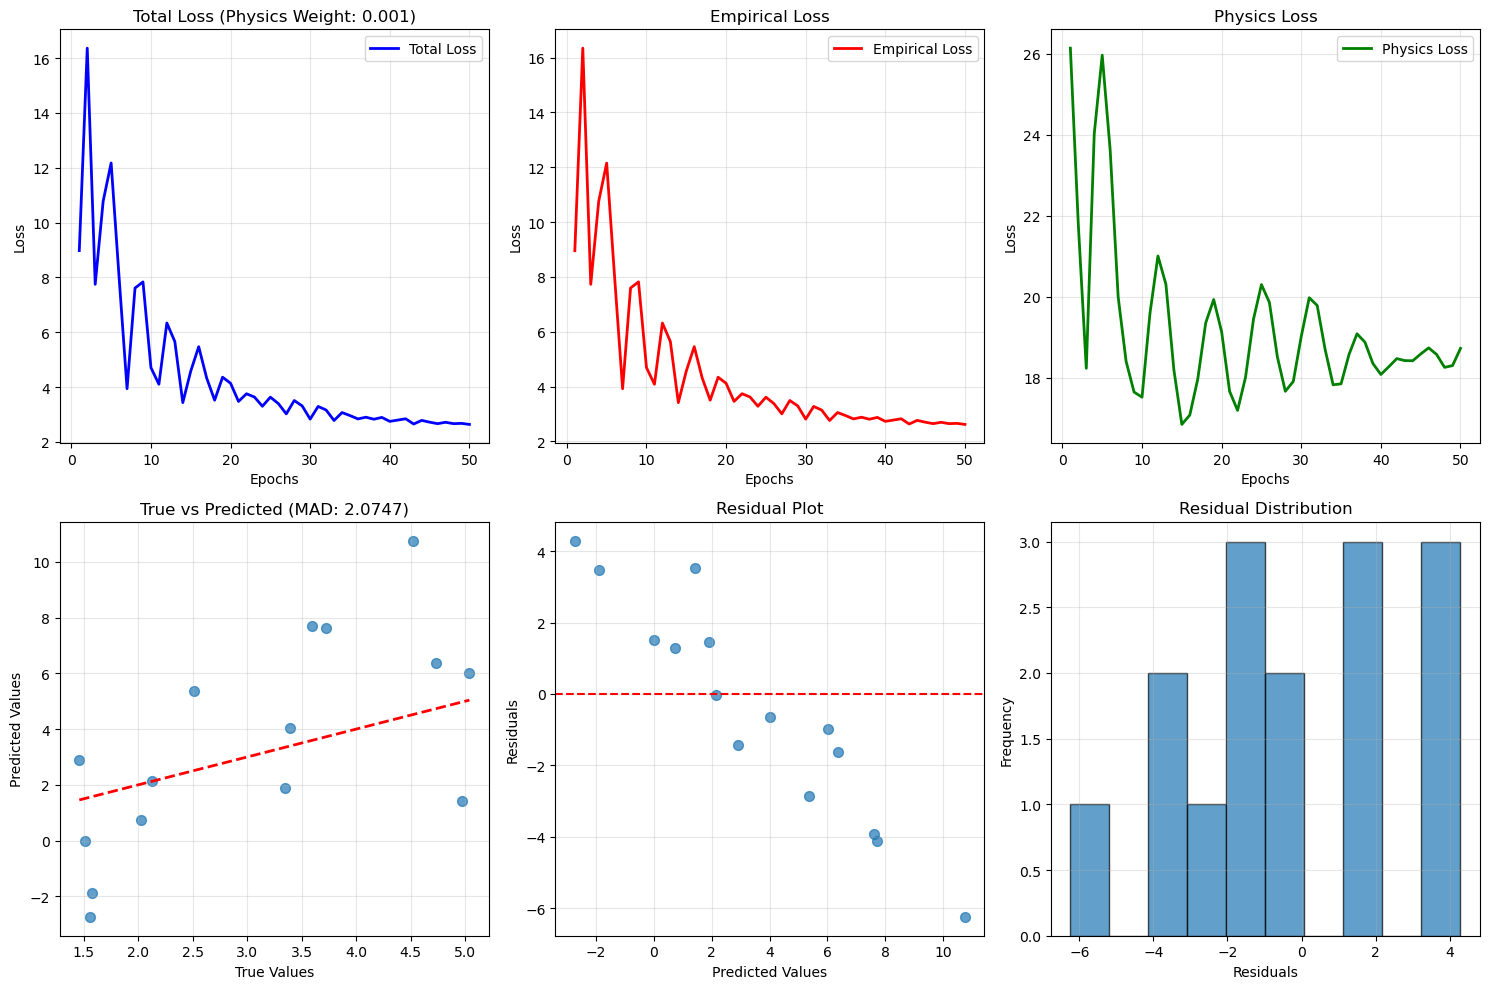

NEW BEST RESULT! Test loss: 3.009360
Completed 0.001 successfully

PROGRESS: 2/3 - Testing physics weight: 0.0025
---------- Physics Weight: 0.0025 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call
Epoch 1/50 - Total: 9.0200, Empirical: 8.9546, Physics: 26.1366
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 25/50 - Total: 3.6641, Empirical: 3.6134, Physics: 20.2968
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside ca

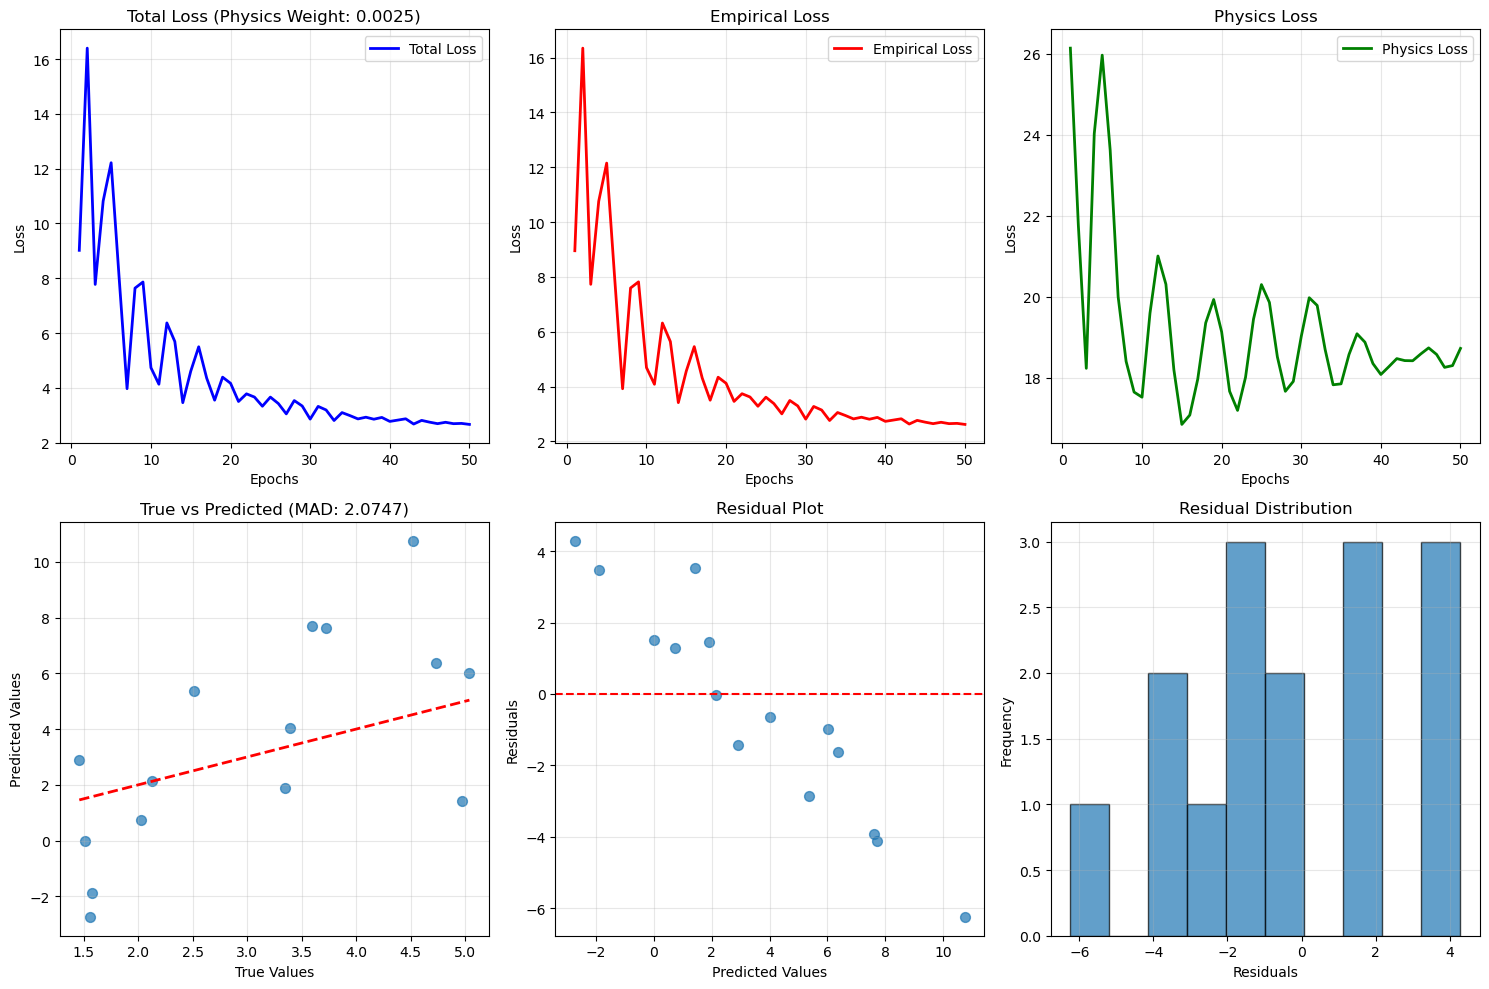

Completed 0.0025 successfully

PROGRESS: 3/3 - Testing physics weight: 0.005
---------- Physics Weight: 0.005 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call
Epoch 1/50 - Total: 9.0853, Empirical: 8.9546, Physics: 26.1366
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 25/50 - Total: 3.7148, Empirical: 3.6134, Physics: 20.2968
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Inside call
Epoch 50/50 - Total: 2.7143, Empiri

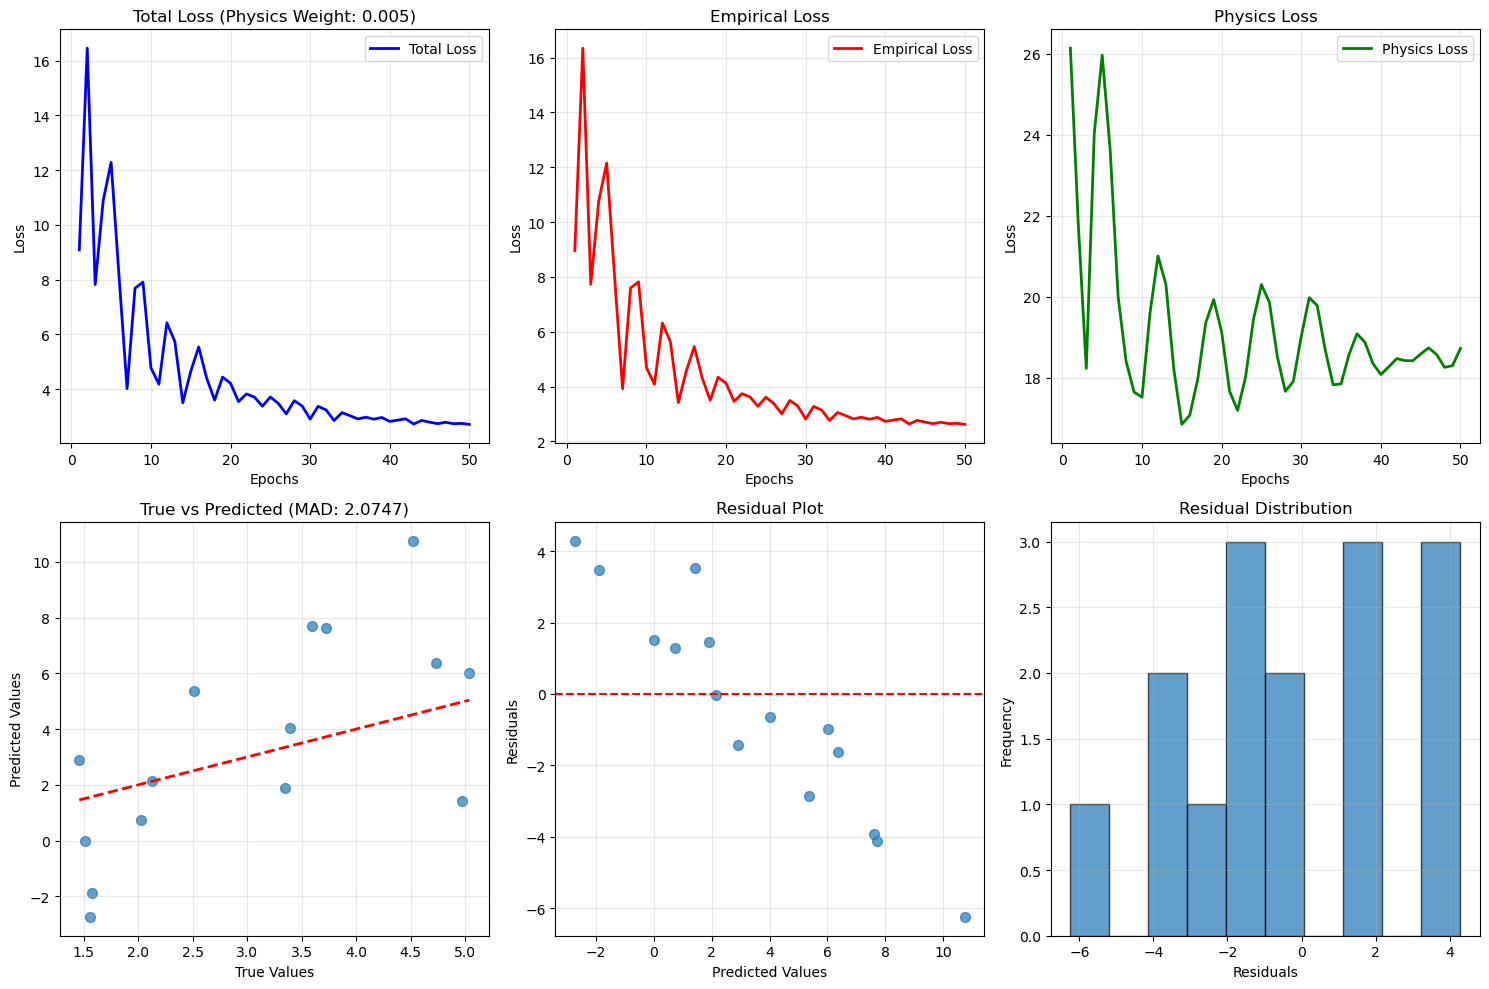

Completed 0.005 successfully

FINAL GRID SEARCH RESULTS
BEST CONFIGURATION:
   Physics weight: 0.001
   Test loss: 3.009360
   MAD: 2.074699
   Epochs completed: 50
   Training time: 160.0s

COMPLETE RESULTS RANKING:
   1. Weight=0.0010: Loss=3.009360, MAD=2.074699, Epochs= 50, Time=160.0s
   2. Weight=0.0025: Loss=3.031337, MAD=2.074699, Epochs= 50, Time=159.7s
   3. Weight=0.0050: Loss=3.067966, MAD=2.074699, Epochs= 50, Time=161.9s


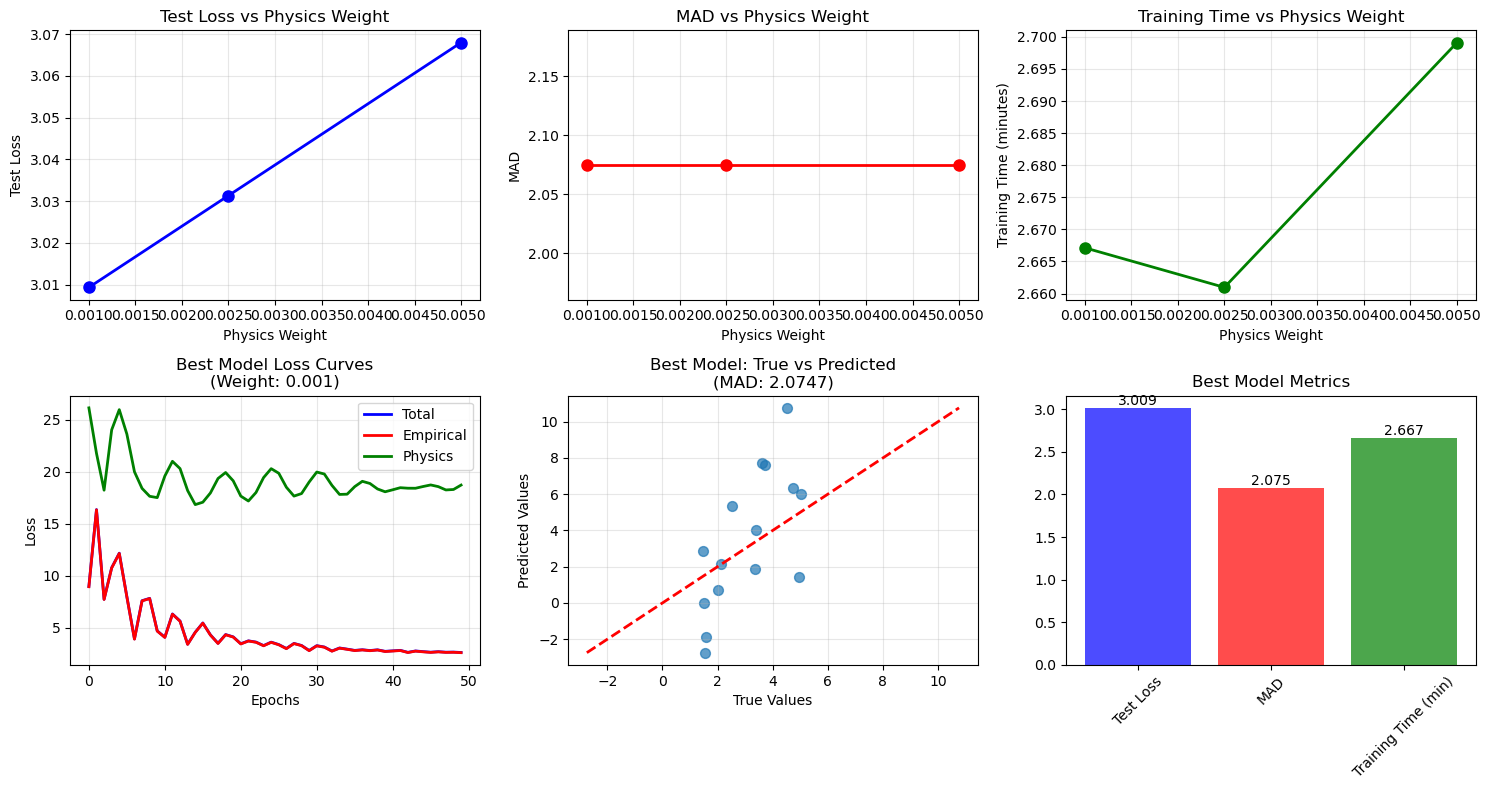

In [21]:
# Optimized and fixed run_search function
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

def run_search(physics_weight, epochs=50):
    # Aggressive session clearing
    tf.keras.backend.clear_session()
    gc.collect()
    
    start_time = time.time()
    print(f"---------- Physics Weight: {physics_weight} ------------")

    # Create fresh copies of data
    X_train_copy = copy.deepcopy(X_train)
    X_test_copy = copy.deepcopy(X_test)
    y_train_copy = copy.deepcopy(y_train)
    y_test_copy = copy.deepcopy(y_test)

    # Create NEW model instance (critical!)
    print("Creating fresh model...")
    m = PGGCN_Hybrid()
    m.addRule("sum", 0, 32)
    m.addRule("multiply", 32, 33)
    m.addRule("distance", 33, 36)

    # Use a fresh optimizer with different random seed
    tf.random.set_seed(int(physics_weight * 10000))  # Different seed per weight
    opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=lr_schedule))

    input_shapes = [X.shape[0] for X in X_train_copy]
    m.set_input_shapes(input_shapes)
    
    # Pad training data
    for i in range(len(X_train_copy)):
        if X_train_copy[i].shape[0] < 2000:
            X_train_copy[i] = np.concatenate([X_train_copy[i], np.zeros([2000 - X_train_copy[i].shape[0], 53])], axis=0)

    # Pad test data
    for i in range(len(X_test_copy)):
        if X_test_copy[i].shape[0] < 2000:
            X_test_copy[i] = np.concatenate([X_test_copy[i], np.zeros([2000 - X_test_copy[i].shape[0], 53])], axis=0)

    # Convert to same type
    X_train_copy = np.array(X_train_copy).astype(np.float32)
    y_train_copy = np.array(y_train_copy).astype(np.float32)
    X_test_copy = np.array(X_test_copy).astype(np.float32)
    y_test_copy = np.array(y_test_copy).astype(np.float32)

    print(f"Training data shape: {X_train_copy.shape}")
    print(f"Test data shape: {X_test_copy.shape}")

    total_losses = []
    empirical_losses = []
    physics_losses = []

    # Early stopping
    best_train_loss = float("inf")
    patience = 15
    patience_counter = 0
    min_delta = 0.001
    best_weights = None

    print("Starting training...")
    training_start = time.time()

    # Training loop with optimizations
    for ep in range(epochs):
        with tf.GradientTape(persistent=True) as tape:
            predictions = m(X_train_copy, training=True)
            
            # Calculate losses
            emp_loss = pure_rmse_hybrid(y_train_copy, predictions[:, 0])
            phy_loss = physical_consistency_loss(y_train_copy, predictions[:, 0], predictions[:, 1:16])
            total_loss = emp_loss + physics_weight * phy_loss

        # Apply gradients
        grads_and_vars = opt.compute_gradients([emp_loss, physics_weight * phy_loss], tape, m.trainable_variables)
        opt.apply_gradients(grads_and_vars)

        # Store losses
        current_total_loss = float(total_loss.numpy())
        total_losses.append(current_total_loss)
        empirical_losses.append(float(emp_loss.numpy()))
        physics_losses.append(float(phy_loss.numpy()))

        # Early stopping logic
        if current_total_loss + min_delta < best_train_loss:
            best_train_loss = current_total_loss
            best_weights = m.get_weights()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {ep + 1}")
                break

        # Print progress every 25 epochs to reduce overhead
        if (ep + 1) % 25 == 0 or ep == 0:
            print(f"Epoch {ep + 1}/{epochs} - Total: {current_total_loss:.4f}, "
                  f"Empirical: {emp_loss.numpy():.4f}, Physics: {phy_loss.numpy():.4f}")
    
    training_time = time.time() - training_start
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Restore best weights
    if best_weights is not None:
        m.set_weights(best_weights)
        print("Restored best weights from training")

    # Evaluation phase
    print("Starting evaluation...")
    eval_start = time.time()
    
    # Initialize prediction list
    y_pred_test = []
    
    # Make predictions
    for i in range(len(X_test_copy)):
        try:
            m.set_input_shapes([X_test_copy[i].shape[0]])
            pred = m(X_test_copy[i][np.newaxis, ...], training=False)
            pred_value = float(pred[0, 0].numpy())
            y_pred_test.append(pred_value)
        except Exception as e:
            print(f"Warning: Prediction {i} failed: {e}")
            y_pred_test.append(0.0)  # Default value
    
    y_pred_test = np.array(y_pred_test)
    eval_time = time.time() - eval_start
    
    print(f"Evaluation completed in {eval_time:.2f} seconds")
    print(f"Predictions shape: {y_pred_test.shape}")
    print(f"Predictions range: [{y_pred_test.min():.4f}, {y_pred_test.max():.4f}]")
    print(f"True values range: [{y_test_copy.min():.4f}, {y_test_copy.max():.4f}]")
    
    # Calculate metrics
    y_difference = np.mean(np.abs(np.abs(y_test_copy) - np.abs(y_pred_test)))
    test_emp_loss = pure_rmse_hybrid(y_test_copy, y_pred_test)
    test_phy_loss = physical_consistency_loss(y_test_copy, y_pred_test, X_test_copy[:, 0, 38:53])
    test_loss = test_emp_loss + physics_weight * test_phy_loss

    end_time = time.time()
    elapsed = end_time - start_time
    
    print(f"Total time: {elapsed:.2f} seconds ({elapsed/60:.1f} minutes)")
    print(f"Mean absolute difference: {y_difference:.6f}")  # More precision
    print(f"Test empirical loss: {float(test_emp_loss.numpy()):.6f}")
    print(f"Test physics loss: {float(test_phy_loss.numpy()):.6f}")
    print(f"Test total loss: {float(test_loss.numpy()):.6f}")

    result_temp = {
        'name': 'ΔΔG with Multi-Loss',
        'y_test': y_test_copy,
        'test_loss': float(test_loss.numpy()),
        'test_emp_loss': float(test_emp_loss.numpy()),
        'test_phy_loss': float(test_phy_loss.numpy()),
        'y_pred_test': y_pred_test,
        'MAD': y_difference,
        'all_losses': total_losses,
        'empirical_losses': empirical_losses,
        'physical_losses': physics_losses,
        'training_time': training_time,
        'eval_time': eval_time,
        'total_time': elapsed,
        'hyperparameters': {
            'physics_weight': physics_weight,
            'epochs': ep + 1 if best_weights is not None else epochs,
            'initial_learning_rate': 0.005,
            'decay_steps': 10000,
            'decay_rate': 0.9
        }
    }

    # Create plots with more detail
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(range(1, len(total_losses) + 1), total_losses, 'b-', label='Total Loss', linewidth=2)
    plt.title(f'Total Loss (Physics Weight: {physics_weight})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 2)
    plt.plot(range(1, len(empirical_losses) + 1), empirical_losses, 'r-', label='Empirical Loss', linewidth=2)
    plt.title('Empirical Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 3)
    plt.plot(range(1, len(physics_losses) + 1), physics_losses, 'g-', label='Physics Loss', linewidth=2)
    plt.title('Physics Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 4)
    plt.scatter(y_test_copy, y_pred_test, alpha=0.7, s=50)
    plt.plot([y_test_copy.min(), y_test_copy.max()], [y_test_copy.min(), y_test_copy.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted (MAD: {y_difference:.4f})')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 5)
    residuals = y_test_copy - y_pred_test
    plt.scatter(y_pred_test, residuals, alpha=0.7, s=50)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 6)
    plt.hist(residuals, bins=10, alpha=0.7, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Explicit cleanup
    del m, X_train_copy, X_test_copy, y_train_copy
    gc.collect()
    
    return result_temp


# Grid search execution with better error handling
def run_full_grid_search():
    weights = [0.001, 0.0025, 0.005]
    results = {}
    all_results = []
    best_loss = float('inf')
    best_result = None

    print("Starting optimized grid search...")
    print(f"Testing {len(weights)} physics weights: {weights}")
    
    for i, w in enumerate(weights):
        print(f"\n{'='*70}")
        print(f"PROGRESS: {i+1}/{len(weights)} - Testing physics weight: {w}")
        print(f"{'='*70}")
        
        try:
            result = run_search(w)
            all_results.append(result)
            results[f"w_{w}"] = result
            
            # Track best result
            if result['test_loss'] < best_loss:
                best_loss = result['test_loss']
                best_result = result
                print(f"NEW BEST RESULT! Test loss: {best_loss:.6f}")
            
            print(f"Completed {w} successfully")
            
        except Exception as e:
            print(f"ERROR with physics weight {w}: {e}")
            # Store error info
            error_result = {
                'name': 'ERROR',
                'test_loss': float('inf'),
                'MAD': float('inf'),
                'error': str(e),
                'hyperparameters': {'physics_weight': w, 'epochs': 0}
            }
            all_results.append(error_result)
            continue
        
        # Progress update
        #remaining = len(weights) - (i + 1)
        #if remaining > 0:
        #    avg_time = (time.time() - start_time) / (i + 1)
        #    est_remaining = avg_time * remaining
        #    print(f"Estimated remaining time: {est_remaining/60:.1f} minutes")

    print(f"\n{'='*70}")
    print("FINAL GRID SEARCH RESULTS")
    print(f"{'='*70}")

    if best_result and best_result['name'] != 'ERROR':
        print(f"BEST CONFIGURATION:")
        print(f"   Physics weight: {best_result['hyperparameters']['physics_weight']}")
        print(f"   Test loss: {best_result['test_loss']:.6f}")
        print(f"   MAD: {best_result['MAD']:.6f}")
        print(f"   Epochs completed: {best_result['hyperparameters']['epochs']}")
        print(f"   Training time: {best_result['training_time']:.1f}s")
        
        print(f"\nCOMPLETE RESULTS RANKING:")
        # Sort results by test loss
        successful_results = [r for r in all_results if r['name'] != 'ERROR']
        successful_results.sort(key=lambda x: x['test_loss'])
        
        for rank, result in enumerate(successful_results, 1):
            pw = result['hyperparameters']['physics_weight']
            tl = result['test_loss']
            mad = result['MAD']
            ep = result['hyperparameters']['epochs']
            tt = result['training_time']
            print(f"   {rank}. Weight={pw:6.4f}: Loss={tl:.6f}, MAD={mad:.6f}, Epochs={ep:3d}, Time={tt:.1f}s")
        
        # Show failed runs
        failed_results = [r for r in all_results if r['name'] == 'ERROR']
        if failed_results:
            print(f"\nFAILED RUNS:")
            for result in failed_results:
                pw = result['hyperparameters']['physics_weight']
                error = result.get('error', 'Unknown error')
                print(f"   Weight={pw}: {error}")
        
        # Create comparison plot
        if len(successful_results) > 1:
            plt.figure(figsize=(15, 8))
            
            # Loss comparison
            plt.subplot(2, 3, 1)
            weights_plot = [r['hyperparameters']['physics_weight'] for r in successful_results]
            losses_plot = [r['test_loss'] for r in successful_results]
            plt.plot(weights_plot, losses_plot, 'bo-', linewidth=2, markersize=8)
            plt.xlabel('Physics Weight')
            plt.ylabel('Test Loss')
            plt.title('Test Loss vs Physics Weight')
            plt.grid(True, alpha=0.3)
            
            # MAD comparison
            plt.subplot(2, 3, 2)
            mad_plot = [r['MAD'] for r in successful_results]
            plt.plot(weights_plot, mad_plot, 'ro-', linewidth=2, markersize=8)
            plt.xlabel('Physics Weight')
            plt.ylabel('MAD')
            plt.title('MAD vs Physics Weight')
            plt.grid(True, alpha=0.3)
            
            # Training time comparison
            plt.subplot(2, 3, 3)
            time_plot = [r['training_time']/60 for r in successful_results]  # Convert to minutes
            plt.plot(weights_plot, time_plot, 'go-', linewidth=2, markersize=8)
            plt.xlabel('Physics Weight')
            plt.ylabel('Training Time (minutes)')
            plt.title('Training Time vs Physics Weight')
            plt.grid(True, alpha=0.3)
            
            # Best model loss curves
            plt.subplot(2, 3, 4)
            if 'all_losses' in best_result:
                plt.plot(best_result['all_losses'], 'b-', label='Total', linewidth=2)
                plt.plot(best_result['empirical_losses'], 'r-', label='Empirical', linewidth=2)
                plt.plot(best_result['physical_losses'], 'g-', label='Physics', linewidth=2)
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title(f'Best Model Loss Curves\n(Weight: {best_result["hyperparameters"]["physics_weight"]})')
                plt.legend()
                plt.grid(True, alpha=0.3)
            
            # Best model predictions
            plt.subplot(2, 3, 5)
            plt.scatter(best_result['y_test'], best_result['y_pred_test'], alpha=0.7, s=50)
            min_val = min(best_result['y_test'].min(), best_result['y_pred_test'].min())
            max_val = max(best_result['y_test'].max(), best_result['y_pred_test'].max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
            plt.xlabel('True Values')
            plt.ylabel('Predicted Values')
            plt.title(f'Best Model: True vs Predicted\n(MAD: {best_result["MAD"]:.4f})')
            plt.grid(True, alpha=0.3)
            
            # Performance summary
            plt.subplot(2, 3, 6)
            components = ['Test Loss', 'MAD', 'Training Time (min)']
            values = [best_result['test_loss'], best_result['MAD'], best_result['training_time']/60]
            colors = ['blue', 'red', 'green']
            bars = plt.bar(components, values, color=colors, alpha=0.7)
            plt.title('Best Model Metrics')
            plt.xticks(rotation=45)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                        f'{value:.3f}', ha='center', va='bottom')
            
            plt.tight_layout()
            plt.show()

    else:
        print("NO SUCCESSFUL RESULTS FOUND!")
        print("All runs failed. Check your model and data.")

    return best_result, all_results, results

# Execute the grid search
print("STARTING OPTIMIZED GRID SEARCH")
print("=" * 70)
best_result, all_results, results = run_full_grid_search()

In [ ]:
#This is another Grid Search cell which will examen weights smaller than 0.001
other_weights = [0.0, 0.00005, 0.0001, 0.00025, 0.0005, 0.00075]

other_best_result = None
other_best_mad = float("inf")
other_results = {}

for weight in other_weights:
    other_results = run_search(weight)
    if other_results["MAD"] < other_best_mad:
        other_best_mad = other_results["MAD"]
        other_best_results = other_result
print("\nBest physics_weight:", other_best_result['hyperparameters']['physics_weight'])
print("Best MAD:", other_best_result['MAD'])
print("Best Test Loss:", other_best_result['test_loss'])

In [ ]:
epoch_length = range(1, len(best_result['empirical_losses']) + 1)
plt.subplot(2, 2, 1)
plt.plot(epoch_length, best_result['empirical_losses'], 'b-', label='Empirical Loss')
plt.title('Empirical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
hybrid_y_true = best_result['y_test']
hybrid_y_pred = best_result['y_pred_test']

In [ ]:
print(hybrid_y_true)
print(hybrid_y_pred)

In [ ]:
epoch_length = range(1, len(best_result['empirical_losses']) + 1)
plt.subplot(2, 2, 1)
plt.plot(epoch_length, best_result['physical_losses'], 'b-', label='Physical Loss')
plt.title('Physical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:


# hist is the History object returned by .fit()
plt.plot(epoch_length, best_result['physical_losses'], 'b-', label='Physical Loss')
plt.title('Physical Loss')

plt.xlabel('Epochs')
plt.ylabel('Physical Loss')
plt.legend()
plt.show()

In [ ]:
print(len(best_result['empirical_losses']))
print(len(best_result['physical_losses']))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Predicted vs.Experimental ΔΔG")
plt.scatter(best_result['y_test'], best_result['y_pred_test'], alpha=0.7, color="purple")
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.tight_layout()
plt.savefig('Model_Performance_Predicted_vs_Experimental_DDG.png',dpi=100, bbox_inches='tight')
plt.show()

## BFE WITHOUT LOSS

In [ ]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])


In [ ]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                 kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                 bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        #self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        final_weights = mn.ruleGraphConvLayer.w_s  # capture after training

        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
       
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


mn= PGGCNModel()
mn.addRule("sum", 0, 32)
mn.addRule("multiply", 32, 33)
mn.addRule("distance", 33, 36)


# PCGrad optimizer
opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=0.005))

# Preprocess input
input_shapes = [x.shape[0] for x in X_train]
mn.set_input_shapes(input_shapes)

for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        padding = np.zeros([2000 - X_train[i].shape[0], 53])
        X_train[i] = np.concatenate([X_train[i], padding], axis=0)

X_train_nohyb = np.array(X_train).astype(np.float32)
y_train_nohyb = np.array(y_train).astype(np.float32)

# Loss tracking
loss_tracker_nohyb = []
epochs = 400

for ep in range(epochs):
    epoch_start = time.time()

    with tf.GradientTape() as tape:
        preds = mn(X_train_nohyb, training=True)
        loss = pure_rmse(y_train_nohyb, preds)

    grads_and_vars = opt.compute_gradients([loss], tape, mn.trainable_variables)
    opt.apply_gradients(grads_and_vars)

    loss_val = float(loss.numpy())
    loss_tracker_nohyb.append(loss_val)

    epoch_end = time.time()
    duration = epoch_end - epoch_start
    duration_str = f"{duration:.0f}s" if duration > 1 else f"{duration*1000:.0f}ms"

    # Displaying Each epoch one by one seems to take up a lot of time
    # Each epoch takes 90s to run, there are 400 so it would finish in 10 hours
    # Unfortunately it also kills the kernel so running at every 10 for now
    if ep % 10 == 0 or ep == epochs - 1:
        print(f"Epoch {ep+1}/{epochs}")
        print(f"1/1 [==============================] - {duration_str} {duration_str}/step - loss: {loss_val:.4f}")


# Plot
plt.plot(range(1, epochs + 1), loss_tracker_nohyb, label="Empirical Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.title("BFE NoHybrid - PCGrad Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
X_test_nohyb = X_test
y_test_nohyb = y_test
input_shapes = []
for i in range(len(X_test_nohyb)):
    input_shapes.append(np.array(X_test_nohyb[i]).shape[0])
mn.set_input_shapes(input_shapes)

for i in range(len(X_test_nohyb)):
    if X_test_nohyb[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 53])
        X_test_nohyb[i] = np.concatenate([X_test_nohyb[i], new_list], 0)
X_test_nohyb = np.array(X_test_nohyb)
x_c = copy.deepcopy(X_test_nohyb)
y_test_nohyb = np.array(y_test_nohyb)
y_pred_test_nohyb = mn.predict(X_test_nohyb) 
y_pred_test_nohyb = np.array(y_pred_test_nohyb)

y_difference_nohyb = np.mean(np.abs(np.abs(y_test_nohyb) - np.abs(y_pred_test_nohyb)))
eval_nohyb = pure_rmse(y_test_nohyb, y_pred_test_nohyb).numpy()
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_nohyb)))


result_temp = {
    'name':'ΔΔG with Traditional RMSE',
    'y_test': y_test_nohyb,
    'test_loss': eval_nohyb,
    'y_pred_test': y_pred_test_nohyb,
    'MAD': y_difference_nohyb,
    'all_losses': loss_tracker_nohyb,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["traditional loss"] = result_temp
all_results.append(result_temp)

In [ ]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(loss_tracker_nohyb, label='train loss')

plt.xlabel('Epoch')
plt.ylabel('Pure RMSE Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Multi-Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, hybrid_y_pred, alpha=0.7,color="purple", label = "Multiloss Function")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('DDG_Predictions_Multi-Loss_vs_RMSE.png',dpi=100, bbox_inches='tight')
plt.show()

## BFE WITH STRUCTURAL

In [ ]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])


In [ ]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCN_Structural(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=False):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
    
    
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


ms = PGGCN_Structural()
ms.addRule("sum", 0, 32)
ms.addRule("multiply", 32, 33)
ms.addRule("distance", 33, 36)

opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=0.005))

# Preprocess input
input_shapes = [x.shape[0] for x in X_train]
ms.set_input_shapes(input_shapes)

for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        padding = np.zeros([2000 - X_train[i].shape[0], 53])
        X_train[i] = np.concatenate([X_train[i], padding], axis=0)

X_train_struct = np.array(X_train).astype(np.float32)
y_train_struct = np.array(y_train).astype(np.float32)

# Loss tracking
loss_tracker_struct = []

# Manual training loop
epochs = 250
for ep in range(epochs):
    epoch_start = time.time()
    with tf.GradientTape() as tape:
        preds = ms(X_train_struct, training=True)
        loss = pure_rmse(y_train_struct, preds)

    grads_and_vars = opt.compute_gradients([loss], tape, ms.trainable_variables)
    opt.apply_gradients(grads_and_vars)

    loss_val = float(loss.numpy())
    loss_tracker_struct.append(loss_val)

    epoch_end = time.time()
    duration = epoch_end - epoch_start
    duration_str = f"{duration:.0f}s" if duration > 1 else f"{duration*1000:.0f}ms"

    print(f"Epoch {ep+1}/{epochs}")
    print(f"1/1 [==============================] - {duration_str} {duration_str}/step - loss: {loss_val:.4f}")

plt.plot(range(1, epochs + 1), loss_tracker_struct, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.title("BFE Structural - PCGrad Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(loss_tracker_struct, label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE and Structural Loss')
plt.legend()
plt.show()

In [ ]:
X_test_struct = X_test
y_test_struct = y_test
input_shapes = []
for i in range(len(X_test_struct)):
    input_shapes.append(np.array(X_test_struct[i]).shape[0])
ms.set_input_shapes(input_shapes)

for i in range(len(X_test_struct)):
    if X_test_struct[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test_struct[i].shape[0], 53])
        X_test_struct[i] = np.concatenate([X_test_struct[i], new_list], 0)
X_test_struct = np.array(X_test_struct)
x_c = copy.deepcopy(X_test_struct)
y_test_struct = np.array(y_test_struct)
y_pred_test_struct = ms.predict(X_test_struct) 
y_pred_test_struct = np.array(y_pred_test_struct)

y_difference_struct = np.mean(np.abs(np.abs(y_test_struct) - np.abs(y_pred_test_struct)))
#eval_struct = ms.evaluate(X_test_struct, y_test_struct)
eval_struct = pure_rmse(y_test_struct, y_pred_test_struct).numpy()
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_struct)))


result_temp = {
    'name':'ΔΔG with Structural Loss Function',
    'y_test': y_test_struct,
    'test_loss': eval_struct,
    'y_pred_test': y_pred_test_struct,
    'MAD': y_difference_struct,
    'all_losses': loss_tracker_struct,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["structural loss"] = result_temp
all_results.append(result_temp)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Structural Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, y_pred_test_struct, alpha=0.7,color="cyan", label = "Structural Loss")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")

plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line

plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('Model_Performance_Structural_vs_Traditional_DDG.png',dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("ΔΔG Comparison between Traditional Loss, Empirical, Physical and Structural Error")
plt.scatter(y_test, y_pred_test_struct, alpha=0.9,color="blue", label = "Structural Error")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="PURE RMSE")
plt.scatter(y_test, hybrid_y_pred, alpha=0.6,color="purple", label="Multi-Loss")

plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-1,12)
plt.ylim(-1, 12)

# Reference y = x line
plt.plot([-1, 12], [-1, 12], color='green', lw=1, linestyle='--')

plt.legend()
plt.tight_layout()

plt.savefig('Emp_Struct_Phy_Loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# Save individual run results
individual_filename = f'/home/lvarga57/multiloss-bfe/FINAL-HOSTGUEST-FILES/Result_Pickle/DDG72_test2_Predictions.pkl'
with open(individual_filename, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to {individual_filename}")